<a href="https://colab.research.google.com/github/fouad89/transformers_tutorials/blob/main/01_transformers_in_Pytorch_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Emotion Detection Task
Six emotions: anger, disgust, fear, joy, sadness and surprices.

Using Distilbert

In [19]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 60.6 MB/s 


In [54]:
!pip install umap-learn[plot]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 65.0 MB/s 
     |████████████████████████████████| 18.2 MB 51.2 MB/s 
     |████████████████████████████████| 76 kB 6.9 MB/s 
     |████████████████████████████████| 837 kB 61.7 MB/s 
     |████████████████████████████████| 830 kB 51.5 MB/s 
     |████████████████████████████████| 822 kB 60.8 MB/s 
     |████████████████████████████████| 802 kB 59.9 MB/s 
     |████████████████████████████████| 802 kB 64.9 MB/s 
     |████████████████████████████████| 793 kB 39.1 MB/s 
     |████████████████████████████████| 793 kB 70.2 MB/s 
     |████████████████████████████████| 791 kB 40.5 MB/s 
     |████████████████████████████████| 786 kB 61.6 MB/s 
     |████████████████████████████████| 779 kB 68.7 MB/s 
     |████████████████████████████████| 778 kB 73.9 MB/s 
     |████████████████████████████

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 15.3 MB/s 
     |████████████████████████████████| 1.1 MB 65.7 MB/s 
     |████████████████████████████████| 212 kB 73.5 MB/s 
     |████████████████████████████████| 140 kB 71.4 MB/s 
     |████████████████████████████████| 86 kB 7.6 MB/s 
     |████████████████████████████████| 596 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 35.8 MB/s 
     |████████████████████████████████| 271 kB 68.0 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 75.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's depe

In [39]:
from datasets import load_dataset, list_datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [4]:
# checking out the number of available datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets")
print(f"The first 10 datasets are: {all_datasets[:10]}")

There are 5829 datasets
The first 10 datasets are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
# load emotions dataset 
emotions = load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds, val_ds, test_ds = emotions['train'], emotions['validation'], emotions['test']

In [8]:
# get column names
train_ds.column_names

['text', 'label']

In [9]:
# get data types
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
# get the first rows
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [11]:
# csv, text and json can also be loaded using
#load_dataset('csv', data_files='my_file.csv', sep='', names=[column_names])

In [12]:
# convert to dataframe
emotions.set_format(type='pandas')
train_df = emotions['train'][:]

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
# converting labels to strings
def label_int2str(row):
    return emotions['train'].features["label"].int2str(row)


train_df['label_name'] = train_df['label'].apply(label_int2str)

In [14]:
train_df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


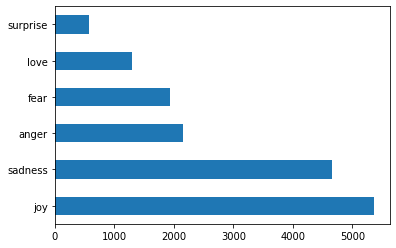

In [15]:
train_df['label_name'].value_counts().plot(kind='barh')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


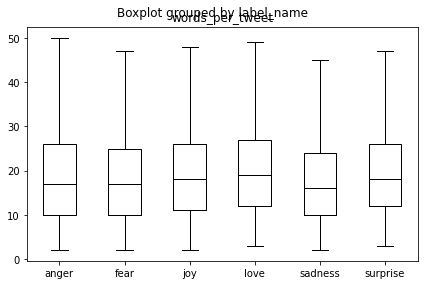

In [16]:
# tweet lengths
train_df['words_per_tweet'] = train_df['text'].str.split().apply(len)

# boxplot 
train_df.boxplot('words_per_tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.xlabel('')

plt.tight_layout()

In [17]:
# convert df back to raw dataset
emotions.reset_format()

## Tokenization

In [20]:
from transformers import AutoTokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [28]:
sample_text = 'This is a test text to see the result of tokenization. The making of NLP'
print(sample_text)

This is a test text to see the result of tokenization. The making of NLP


In [25]:
encoded_text = tokenizer(sample_text)

print(encoded_text)

{'input_ids': [101, 2023, 2003, 1037, 3231, 3793, 2000, 2156, 1996, 2765, 1997, 19204, 3989, 1012, 1996, 2437, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
# identifying the tokenz
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'this', 'is', 'a', 'test', 'text', 'to', 'see', 'the', 'result', 'of', 'token', '##ization', '.', 'the', 'making', 'of', 'nl', '##p', '[SEP]']


In [29]:
# converting tokens back to text
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] this is a test text to see the result of tokenization. the making of nlp [SEP]


In [31]:
# information about tokenizer
print(f'Number of tokens in tokenizer: {tokenizer.vocab_size}')
print(f'Max Length of context size {tokenizer.model_max_length}')

print(f'Model inputs: {tokenizer.model_input_names}')

Number of tokens in tokenizer: 30522
Max Length of context size 512
Model inputs: ['input_ids', 'attention_mask']


# Tokenizing a Dataset

In [32]:
# using the map function from the DatasetDict object
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [33]:
## Tokenzing the first two sentences in the dataset
print(tokenize(emotions['train'][:2])) 

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
# special tokens
## [PAD] --ID 0
## [UNK] -- ID 100
## [CLS] -- ID 101
## [SEP] -- ID 102
## [MASK] -- ID 103

In [34]:
tokenizer?

In [37]:
# applying the tokenize to the whol dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Parameter 'function'=<function tokenize at 0x7ff2d4185cb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [38]:
# checking the column names 
emotions_encoded.column_names

{'test': ['text', 'label', 'input_ids', 'attention_mask'],
 'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask']}

In [41]:
## using pretrained models
from transformers import AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModel.from_pretrained(model_name).to(device)

cuda


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# extracting the last hidden states
print(sample_text)
inputs = tokenizer(sample_text, return_tensors='pt')
print(f'Input tensor shape: {inputs["input_ids"].size()}') # gives [batch_size, n_tokens]

This is a test text to see the result of tokenization. The making of NLP
Input tensor shape: torch.Size([1, 20])


In [45]:
# placing into device
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)


print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.3338, -0.3289, -0.2247,  ..., -0.2365, -0.0306,  0.6055],
         [-0.4887, -0.3293, -0.2985,  ..., -0.0362,  0.4194,  0.3675],
         [-0.4137, -0.1777,  0.0921,  ...,  0.0405, -0.1687,  0.7163],
         ...,
         [-0.0196, -0.7519,  0.0925,  ..., -0.2378, -0.0953,  0.4196],
         [-0.2664, -0.4697, -0.3143,  ..., -0.0691, -0.5415,  0.1504],
         [ 0.7452, -0.0269, -0.5501,  ...,  0.1328, -0.8087, -0.1941]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [46]:
outputs.last_hidden_state.size() # [batch_size, n_tokens, hidden_dim]

torch.Size([1, 20, 768])

In [47]:
# getting hidden states for data
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}
    

In [48]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [49]:
# setting the format to torch
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [50]:
# extracting hidden stats
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [51]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating Feature Matrix

In [52]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the training set

In [56]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [58]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
# initializing and fitting UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb['label'] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.397395,6.237845,0
1,-2.727878,6.118415,0
2,5.311095,2.735667,3
3,-2.273457,3.608430,2
4,-3.201446,4.040233,3


In [59]:
df_emb.shape

(16000, 3)

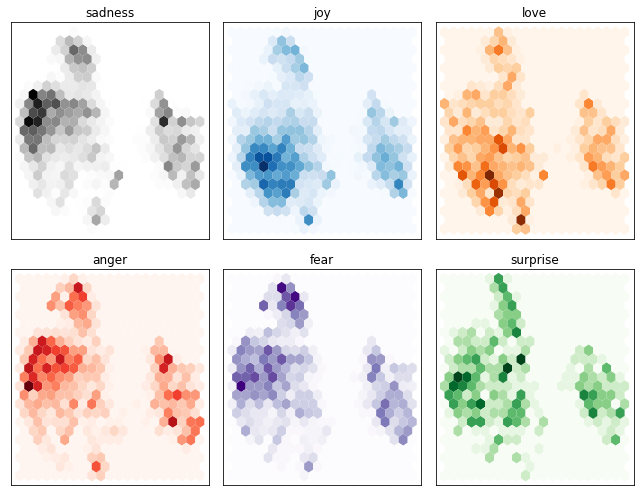

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(9,7))
axes = axes.flatten()
cmaps = ['Greys','Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [63]:
## Baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [64]:
# Logistic Reg
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

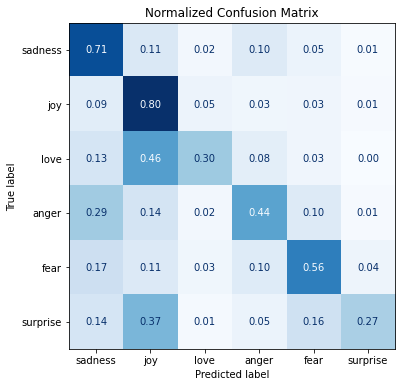

In [65]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning Transformers